## Cleaning the dataset ##

Cleansing of the dataset: removal of unimportant features, NaN elements, parsing of some elements.

In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import statistics as stat
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json

### 1. Merging dataframes ###

Merge the information from two separate datasets

In [7]:
all_movies_new =     pd.read_csv('350000-movies/AllMoviesDetailsCleaned.csv', sep=';', encoding='utf-8', low_memory=False,
                                 error_bad_lines=False)
all_movies_casting = pd.read_csv('350000-movies/AllMoviesCastingRaw.csv', sep=';', encoding='utf-8', low_memory=False,
                                 error_bad_lines=False)

In [8]:
print('There are {} movies'.format(len(all_movies_new)))
print('There are {} casting infos'.format(len(all_movies_casting)))

There are 329044 movies
There are 329044 casting infos


In [9]:
all_movies_casting.head(10)

,id,actor1_name,actor1_gender,actor2_name,actor2_gender,actor3_name,actor3_gender,actor4_name,actor4_gender,actor5_name,actor5_gender,actor_number,director_name,director_gender,director_number,producer_name,producer_number,screeplay_name,editor_name
0,2,Turo Pajala,0,Susanna Haavisto,0.0,Matti Pellonpää,2,Eetu Hilkamo,0,none,0,4,Aki Kaurismäki,0.0,1,none,0,Aki Kaurismäki,Raija Talvio
1,3,Matti Pellonpää,2,Kati Outinen,1.0,Sakari Kuosmanen,2,Esko Nikkari,2,Kylli Köngäs,0,7,Aki Kaurismäki,0.0,1,Mika Kaurismäki,1,Aki Kaurismäki,Raija Talvio
2,5,Tim Roth,2,Antonio Banderas,2.0,Jennifer Beals,1,Madonna,1,Marisa Tomei,1,24,Allison Anders,1.0,4,Lawrence Bender,1,none,Margaret Goodspeed
3,6,Emilio Estevez,2,Cuba Gooding Jr.,2.0,Denis Leary,2,Jeremy Piven,2,Peter Greene,2,15,Stephen Hopkins,2.0,1,Gene Levy,1,Lewis Colick,Tim Wellburn
4,8,none,0,none,0.0,none,0,none,0,none,0,0,Timo Novotny,0.0,1,Timo Novotny,2,Michael Glawogger,Timo Novotny
5,9,Rita Lengyel,1,Milton Welsh,2.0,none,0,none,0,none,0,2,Marc Meyer,0.0,2,Marc Meyer,1,none,Marc Meyer
6,11,Mark Hamill,2,Harrison Ford,2.0,Carrie Fisher,1,Peter Cushing,2,Alec Guinness,2,106,George Lucas,2.0,1,Gary Kurtz,2,none,Marcia Lucas
7,12,Albert Brooks,2,Ellen DeGeneres,1.0,Alexander Gould,2,Willem Dafoe,2,Brad Garrett,2,24,Andrew Stanton,2.0,1,Graham Walters,1,Andrew Stanton,David Ian Salter
8,13,Tom Hanks,2,Robin Wright,1.0,Gary Sinise,2,Mykelti Williamson,2,Sally Field,1,67,Robert Zemeckis,2.0,1,Wendy Finerman,3,Eric Roth,Arthur Schmidt
9,14,Kevin Spacey,2,Annette Bening,1.0,Thora Birch,1,Wes Bentley,2,Mena Suvari,1,41,Sam Mendes,2.0,1,Bruce Cohen,2,Alan Ball,Christopher Greenbury


Merge while taken into account duplicate columns

In [10]:
cols_to_use = all_movies_casting.columns.difference(all_movies_new.columns)
df = all_movies_new.merge(all_movies_casting, left_index=True, right_index=True, how='outer')
print('We have {} movies after merging'.format(len(df)))

We have 329044 movies after merging


### 2. Data cleaning###

Remove columns with unimportant features, movies with NaN entries, zeros for the budget or the revenue. Non english films are also removed.

In [11]:
df.drop(['spoken_languages_number','production_countries_number', 'status', 'runtime', 'actor_number', 'actor5_gender',
         'actor4_gender', 'actor3_gender', 'actor2_gender', 'actor1_gender', 'director_number', 'producer_number',
         'director_gender', 'original_title', 'popularity', 'production_countries', 'spoken_languages', 'vote_count',
         'vote_average', 'producer_name', 'screeplay_name', 'editor_name','production_companies_number'],
         axis=1, inplace = True)

df = df.drop(df[df.budget < 1000].index)
df = df.drop(df[df.revenue == 0].index)
df = df.drop(df[df.original_language != 'en'].index)
df = df.drop(df[df.director_name == 'none'].index)
df = df.drop(df[df.production_companies == 'none'].index)
df = df.drop(df[df['imdb_id'].isnull()].index)
df = df.drop(df[df['genres'].isnull()].index)

df['imdb_id'] = df['imdb_id'].str.replace('tt', '') 
df.drop(['id_y'],axis=1, inplace = True)
df.rename(columns={'id_x': 'id'}, inplace=True)
df.drop(['original_language'],axis=1, inplace = True)
df['release_date'] = pd.to_datetime(df['release_date'])

print('There are {} movies left in the dataframe'.format(len(df)))

There are 4625 movies left in the dataframe


Retain only the movies between the year 2000 and 2017 (not included since we consider that the revenue of some of them are not yet fixed)

In [12]:
print('There are {} movies before 2000'.format(len(df[df.release_date <= '1999-12-31'])))
print('There are {} movies after 2016'.format(len(df[df.release_date >= '2017-01-01'])))
print('{} movies would be dropped'. format(len(df[df.release_date <= '1999-12-31']) + len(df[df.release_date >= '2017-06-01'])))

There are 1809 movies before 2000
There are 40 movies after 2016
1824 movies would be dropped


In [13]:
df = df.drop(df[df.release_date <= '1999-12-31'].index)
df = df.drop(df[df.release_date >= '2017-01-01'].index)
print('There are {} movies left in the dataset'.format(len(df)))

There are 2776 movies left in the dataset


In [14]:
df.head()

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,tagline,title,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_name
7,12,94000000,Animation|Family,0266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,Albert Brooks,Ellen DeGeneres,Alexander Gould,Willem Dafoe,Brad Garrett,Andrew Stanton
11,16,12800000,Drama|Crime|Music,0168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,You don't need eyes to see.,Dancer in the Dark,Björk,Catherine Deneuve,David Morse,Peter Stormare,Joel Grey,Lars von Trier
17,22,140000000,Adventure|Fantasy|Action,0325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,Johnny Depp,Geoffrey Rush,Orlando Bloom,Keira Knightley,Jack Davenport,Gore Verbinski
18,24,30000000,Action|Crime,0266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Go for the kill.,Kill Bill: Vol. 1,Uma Thurman,Lucy Liu,Vivica A. Fox,Daryl Hannah,David Carradine,Quentin Tarantino
19,25,72000000,Drama|War,0418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Welcome to the suck.,Jarhead,Jamie Foxx,Scott MacDonald,none,Lucas Black,Peter Sarsgaard,Sam Mendes


In [15]:
df.to_csv('Saved_Datasets/CleanDataset.csv', index=False)

### 3. Rearrange columns

In [3]:
df = pd.read_csv('Saved_Datasets/CleanDataset.csv')
len(df) #verification

2621

#### 3.1 Give an ID for each actor / director

In [4]:
#generate dictionnaries assigning ids for each actor/director

actor_dict = {}
director_dict = {}

actors = pd.concat([df['actor1_name'], df['actor2_name'], df['actor3_name'], df['actor4_name'], df['actor5_name']])
actors = actors[actors != 'none']
actors = actors.unique()

directors = df['director_name'].unique()

for i in range(0,len(actors)):
    actor_dict[actors[i]] = i

for i in range(0,len(directors)):
    director_dict[directors[i]] = i

In [5]:
#function to create list of actor for each movie (and ignore 'none')
def merge_actors(actor_list,mode='name',actor_dict={}):
    ''' mode "name" : (default) return same list as actor_list, but without "none"
        mode "id"   :           return id of actor. id dictionnary must be provided in actor_dict.
    '''
    
    id_l = []
    for actor in actor_list:
        if actor != 'none':
            if (mode == 'id' and len(actor_dict)>0):
                id_l.append(actor_dict[actor])
            else:
                id_l.append(actor)
                
    return id_l

In [6]:
#add list of actor's id to each movie in dataset
df['director_id'] = df.apply(lambda row: director_dict[row['director_name']], axis=1)
df['actor_names'] = df.apply(lambda row: merge_actors([row['actor1_name'], row['actor2_name'],row['actor3_name'],
                                                          row['actor4_name'], row['actor5_name']],'name'), axis=1)
df['actor_ids']   = df.apply(lambda row: merge_actors([row['actor1_name'], row['actor2_name'],row['actor3_name'],
                                                          row['actor4_name'], row['actor5_name']],'id',actor_dict), axis=1)

In [7]:
#Remove actors columns
df.drop(['actor1_name','actor2_name','actor3_name','actor4_name','actor5_name'],axis=1, inplace = True)

In [8]:
#Remove movies without any actor
df = df[df['actor_ids'].str.len() != 0]

#### 3.2 Add Metacritic ratings

Merge with csv created in Get_Metacritic_ratings

In [9]:
#load critics from external file
metacritic_ratings = pd.read_csv('Saved_Datasets/metacritic_ratings.csv')
len(metacritic_ratings)

2776

In [10]:
#merge dataframes
df = pd.merge(df,metacritic_ratings,on=['imdb_id','title'])

In [11]:
#Remove Movies without Metacritic rating
df = df.drop(df[df.Metacritic == 'Error'].index)

#### 3.4 YouTube Views

In [3]:
#load views from external file
views = pd.read_csv('Saved_Datasets/YouTube_views.csv')
len(views)

2621

In [4]:
#merge dataframes
df = pd.merge(df,views,on=['imdb_id','title'])

#### 3.5 Final Cleaning

In [ ]:
df.drop(['tagline','director_id','actor_ids'],axis=1, inplace = True)

#### 3.6. Save CleanDataset

In [20]:
print(len(df))
df.head(50)

2621


,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,...,actors_ids,actors_tenures,total_tenure,average_tenure,Total_profitability_actors,Metacritic,YouTube_Mean,Profitability,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,...,"[14, 5293, 12, 13, 18]","[18, 24, 2, 28, 14]",86,17.20,7310194071,90,0.218,846335536,2.639,1
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,...,"[6748, 47, 52, 50, 53]","[49, 19, 21, 44, 15]",148,29.60,294261790,61,Error,27231879,2.127,1
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,...,"[1709, 116, 114, 118, 85]","[7, 9, 7, 22, 20]",65,13.00,15077223101,63,1.0,515011224,2.639,1
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Kill Bill: Vol. 1,Quentin Tarantino,...,"[140, 589, 2535, 139, 141]","[12, 26, 15, 17, 39]",109,21.80,1994329604,69,1.0,150949000,2.639,1
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Jarhead,Sam Mendes,...,"[133, 134, 1350483, 155]","[11, 14, 0, 12]",37,9.25,2367434946,58,1.0,24889998,0.346,1
5,27,1000000,Drama|Music|Romance,411705,"Matt, a young glaciologist, soars across the v...",Revolution Films,2004-07-16,1574623,9 Songs,Michael Winterbottom,...,"[1357012, 177, 1759261, 1087657]","[1, 1, 1, 18, 15]",36,7.20,2298492,43,Error,574623,0.575,1
6,35,75000000,Animation|Comedy|Family,462538,After Homer accidentally pollutes the town's w...,Gracie Films,2007-07-25,527068851,The Simpsons Movie,David Silverman,...,"[199, 5587, 5586, 198, 200]","[33, 18, 23, 22, 27]",123,24.60,3427993239,80,Error,452068851,2.639,1
7,38,20000000,Science Fiction|Drama|Romance,338013,"Joel Barish, heartbroken that his girlfriend u...",Anonymous Content,2004-03-19,72258126,Eternal Sunshine of the Spotless Mind,Michel Gondry,...,"[103, 206, 205, 109, 204]","[11, 24, 16, 16, 11]",78,15.60,10973717071,89,0.148,52258126,2.613,1
8,58,200000000,Adventure|Fantasy|Action,383574,Captain Jack Sparrow works his way out of a bl...,Walt Disney Pictures,2006-06-20,1065659812,Pirates of the Caribbean: Dead Man's Chest,Gore Verbinski,...,"[116, 114, 1640, 85, 2440]","[12, 10, 35, 23, 27]",107,21.40,18153570766,53,0.001,865659812,2.639,1
9,59,32000000,Drama|Thriller|Crime,399146,An average family is thrust into the spotlight...,New Line Cinema,2005-09-23,60740827,A History of Violence,David Cronenberg,...,"[110, 225, 49, 226, 227]","[21, 9, 8, 1, 28]",67,13.40,3223414068,81,0.255,28740827,0.898,1


In [7]:
df.to_csv('Saved_Datasets/CleanDataset.csv', encoding='utf-8', index=False)

### 4. Add New Features

In [2]:
df = pd.read_csv('Saved_Datasets/CleanDataset.csv')
len(df) #verification

2621

#### 4.1 Compute ROI

In [3]:
df['ROI'] = df.apply(lambda row: np.round((row['revenue']-row['budget'])/row['budget'],3), axis=1)

Saturate rows with ROI too high: saturates the 25% highest ROIs

In [4]:
quartile = np.round(np.percentile(df.ROI,75),3)
print("Quartile = "+str(quartile))

df.loc[df.ROI>quartile,'ROI'] = quartile

Quartile = 2.639


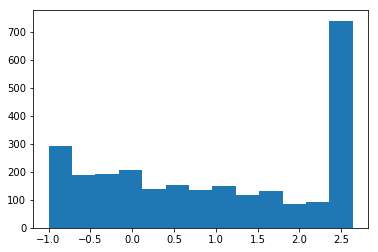

In [5]:
plt.hist(df.ROI,bins='auto');

#### 4.2 Compute Success

Add "success" column: a movie is successful if its ROI belongs to the top 75%

In [4]:
def classify_success(roi):
    #if (roi >= np.round(np.percentile(df.ROI,75),3)): return 1
    #if (roi >= np.round(np.percentile(df.ROI,50),3)): return 3
    if (roi >= np.round(np.percentile(df.ROI,25),3)): return 1
    else: return 0

In [5]:
df['success'] = df.apply(lambda row: classify_success(row['ROI']), axis=1)

#### 4.3 Associate actors tmdb ids to movies of the dataset

In [9]:
Actors = pd.read_csv('Saved_Datasets/Actorsv4Dataset.csv')

In [10]:
#Assign actors TMDb ids to a movie in the dataset
def one_movies_actor_id(movies):
    actor_index = [i for i, item in enumerate(Actors['Name']) if item in df['actor_names'][movies]]
    #print(index_movie)
    one_movie_actor_id = []
    for i in actor_index:
        one_movie_actor_id.append(Actors['tmdb_id'][i])
    #print(one_actor_movie_date)    
    return one_movie_actor_id #ATTENTION ORDRE ACTTEUR MOVIE PAS GARDE

In [11]:
#Apply actors TMDb ids to the whole dataset
movies_actors_ids = list(map(one_movies_actor_id,np.arange(len(df))))

In [12]:
idx = df.columns.get_loc('actor_names')
df.insert(idx+1,'actors_ids',movies_actors_ids)

#### 4.4 Associate actors tenures to movies of the dataset

In [13]:
#Forming data in column actor_names
df['actor_names']=df['actor_names'].str.replace('"','')
df['actor_names'] = df['actor_names'].str.replace("'",'')
df['actor_names'] = df['actor_names'].str.replace(", ",',')

In [14]:
#Convert string in dataset['actor_names'] into list
df['actor_names'] = df.actor_names.apply(lambda x: x[1:-1].split(","))

In [15]:
Actors['date'] = Actors['date'].str.replace("'",'')

In [16]:
Actors['date'] = Actors.date.apply(lambda x: x[1:-1].split(","))

In [17]:
def one_actor_tenure_movie(movies):
    actor_index = [i for i, item in enumerate(Actors['Name']) if item in df['actor_names'][movies]]
    tenure=[]
    for i in actor_index:
        if Actors['date'][i][0] !='':
            ten = int(df['release_date'][movies][0:4])-int(Actors['date'][i][0])+1
            #print(ten)
            if (ten <0):
                ten = 0
            if (ten > 72):
                ten = 72
            tenure.append (ten)
        else:
            tenure.append(0) 
    return tenure

In [18]:
movie_tenures = list(map(one_actor_tenure_movie,np.arange(len(df))))

In [19]:
idx = df.columns.get_loc('actors_ids')
df.insert(idx+1,'actors_tenures',movie_tenures)

#### 4.5 Compute total tenures and averaged tenures of movies in the dataset

In [20]:
#Compute total tenure of each movie
movie_tenure_sum = []
for i in range(0,len(df)):
    movie_tenure_sum.append(sum(df['actors_tenures'][i]))
    

In [21]:
idx = df.columns.get_loc('actors_tenures')
df.insert(idx+1,'total_tenure',movie_tenure_sum)

In [22]:
#Compute average tenure of each movie
movie_tenure_average = []
for i in range(0,len(df)):
    #print(movie_tenures[i])
    if df['actors_tenures'][i] != []:
        movie_tenure_average.append(stat.mean(df['actors_tenures'][i]))
    else:
        movie_tenure_average.append(0)

In [23]:
idx = df.columns.get_loc('total_tenure')
df.insert(idx+1,'average_tenure',movie_tenure_average)

#### 4.6 Compute Profitability

In [24]:
prof = df['revenue']-df['budget']

In [25]:
idx = df.columns.get_loc('Metacritic')
df.insert(idx+1,'Profitability',prof)

#### 4.7 Compute Profitability of Actors in movies ####

In [26]:
### Compute actor profitabtility to one movie of the dataset
def one_movies_actor_prof(movies):
    #print(movies_actors_ids[movies])
    #print(len(Actors['tmdb_id']))
    #print(Act_prof['actors_ids'])
    actor_index = [i for i, item in enumerate(Actors['tmdb_id']) if item in movies_actors_ids[movies]]
    #print(actor_index)
    one_movie_actor_prof = []
    for i in actor_index:
        #print(i)
        one_movie_actor_prof.append(Actors['Profitability'][i])
    prof = sum(one_movie_actor_prof)  
    return prof 

In [27]:
test = one_movies_actor_prof(0)
print(test)

7310194071


In [28]:
movies_actor_prof = list(map(one_movies_actor_prof,np.arange(len(df))))

In [29]:
idx = df.columns.get_loc('average_tenure')
df.insert(idx+1,'Total_profitability_actors',movies_actor_prof)

### 5. Save NewFeatures Dataset

In [21]:
df.head(40)

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,...,actors_ids,actors_tenures,total_tenure,average_tenure,Total_profitability_actors,Metacritic,YouTube_Mean,Profitability,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,...,"[14, 5293, 12, 13, 18]","[18, 24, 2, 28, 14]",86,17.20,7310194071,90,0.218,846335536,2.639,1
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,...,"[6748, 47, 52, 50, 53]","[49, 19, 21, 44, 15]",148,29.60,294261790,61,Error,27231879,2.127,1
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,...,"[1709, 116, 114, 118, 85]","[7, 9, 7, 22, 20]",65,13.00,15077223101,63,1.0,515011224,2.639,1
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Kill Bill: Vol. 1,Quentin Tarantino,...,"[140, 589, 2535, 139, 141]","[12, 26, 15, 17, 39]",109,21.80,1994329604,69,1.0,150949000,2.639,1
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Jarhead,Sam Mendes,...,"[133, 134, 1350483, 155]","[11, 14, 0, 12]",37,9.25,2367434946,58,1.0,24889998,0.346,1
5,27,1000000,Drama|Music|Romance,411705,"Matt, a young glaciologist, soars across the v...",Revolution Films,2004-07-16,1574623,9 Songs,Michael Winterbottom,...,"[1357012, 177, 1759261, 1087657]","[1, 1, 1, 18, 15]",36,7.20,2298492,43,Error,574623,0.575,1
6,35,75000000,Animation|Comedy|Family,462538,After Homer accidentally pollutes the town's w...,Gracie Films,2007-07-25,527068851,The Simpsons Movie,David Silverman,...,"[199, 5587, 5586, 198, 200]","[33, 18, 23, 22, 27]",123,24.60,3427993239,80,Error,452068851,2.639,1
7,38,20000000,Science Fiction|Drama|Romance,338013,"Joel Barish, heartbroken that his girlfriend u...",Anonymous Content,2004-03-19,72258126,Eternal Sunshine of the Spotless Mind,Michel Gondry,...,"[103, 206, 205, 109, 204]","[11, 24, 16, 16, 11]",78,15.60,10973717071,89,0.148,52258126,2.613,1
8,58,200000000,Adventure|Fantasy|Action,383574,Captain Jack Sparrow works his way out of a bl...,Walt Disney Pictures,2006-06-20,1065659812,Pirates of the Caribbean: Dead Man's Chest,Gore Verbinski,...,"[116, 114, 1640, 85, 2440]","[12, 10, 35, 23, 27]",107,21.40,18153570766,53,0.001,865659812,2.639,1
9,59,32000000,Drama|Thriller|Crime,399146,An average family is thrust into the spotlight...,New Line Cinema,2005-09-23,60740827,A History of Violence,David Cronenberg,...,"[110, 225, 49, 226, 227]","[21, 9, 8, 1, 28]",67,13.40,3223414068,81,0.255,28740827,0.898,1


In [22]:
df.to_csv('Saved_Datasets/NewFeaturesDataset.csv', encoding='utf-8', index=False)